In [11]:
# import librosa
# from librosa.feature import melspectrogram
# from librosa.core import load
from librosa.display import specshow
from librosa import power_to_db
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import pickle
import numpy as np
import matplotlib.pyplot as plt


# from utils.preprocessing import extract_log_mel_feats

Чуть чуть изменила ваш скрипт, что бы загрузить уже сохраненные данные с гугл 
диска (которые я получила на локальном компьютере)

In [2]:
# путь к файлам
path = "E:/stady/acoustic_event_analysis/"

In [4]:
# считываем дынные из файла
with open(path + 'train.pickle', 'rb') as f:
    pickle_train_data = pickle.load(f)

In [5]:
# pip install SoundFile

In [6]:
import numpy as np
import pandas as pd
import soundfile as sf
import torch.nn.functional as F
import torch.nn as nn
import torch
import torch.optim as optim


class DummyNetwork(nn.Module):
    def __init__(self):
        super(DummyNetwork, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, stride=(2, 2))
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3, stride=(1, 1))
        self.conv3 = nn.Conv2d(in_channels=96, out_channels=64, kernel_size=3, stride=(1, 1))
        
        self.mp = nn.MaxPool2d(kernel_size=(2, 2), stride=(1, 1))
        
        self.dropout1 = nn.Dropout(p=0.3)
        self.dropout2 = nn.Dropout(p=0.3)
        self.dropout3 = nn.Dropout(p=0.3)
        
        self.bn1 = nn.BatchNorm2d(num_features=64)
        self.bn2 = nn.BatchNorm2d(num_features=96)
        self.bn3 = nn.BatchNorm2d(num_features=64)
        
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(33856, 41)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout3(x)
        
        x = self.flat(x)
        # здесь можно еще добавить полносвязных слой или слои
        x = self.fc1(x)
        return x


In [7]:
# random_input = torch.randn(1, 1, 128, 64, requires_grad=True)
# network = DummyNetwork()
# output = network(random_input)
# print(output.shape)

In [8]:
def prepare_shape(feature):
    tmp = feature
    N = 64 # размер во времени (можно увеличить, должно стать лучше)
    while tmp.shape[1] < N:
        # можно попробовать сделать np.pad для коротких файлов, вместо повторения до необходимой длины
        tmp = np.hstack((tmp, tmp))
    # случайный сдвиг должен улучшить результат (для этого нужно функцию перенести в EventDetectionDataset)
    tmp = tmp[np.newaxis, :, :N]
    return tmp

In [27]:
labels = []
feature = []
for i, row in enumerate(pickle_train_data):
    feature.append(prepare_shape(row['feature']))
    labels.append(row['label_id'])

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
train_data, test_data, train_label, test_label = train_test_split(feature, labels, test_size=0.30, random_state=42)

In [9]:
# # разбивку делала в ручную, чтобы сохранить пропорции
# # разбиваем признаки и метки на test и train
# # для этого необходимо создать словарь, где ключь - это метки, 
# # значения - это список массивов признаков для каждой метки
# all_dict = {}
# for _, row in enumerate(pickle_train_data):
#     if row['label_id'] in all_dict:
#         all_dict.update({row['label_id']: all_dict[row['label_id']] + [prepare_shape(row['feature'])]})
#     else:
#         all_dict.update({row['label_id']: [prepare_shape(row['feature'])]}) 

In [10]:
# # делим данные на test(30%), train(70%)
# train_data = []
# train_label = []
# test_data = []
# test_label = []

# for k_new_dict, v_new_dict in all_dict.items():
#   count = 0
#   for i in v_new_dict:
#     count += 1
#     if count <= round(len(v_new_dict)*0.7):
#       train_data.append(i) # добавляем в словарь массив признаков
#       train_label.append(k_new_dict) # добавляем в словарь метку массива признаков
#     else:
#       test_data.append(i) # добавляем в словарь массив признаков
#       test_label.append(k_new_dict)  # добавляем в словарь метку массива признаков

In [30]:
print(len(train_data), len(train_label))
print(len(test_data), len(test_label))

3978 3978
1705 1705


In [32]:
x_test = np.asarray(test_data)
x_tr = np.asarray(train_data)

y_test = np.asarray(test_label)
y_tr = np.asarray(train_label)

In [33]:
from torch.utils.data import Dataset


class EventDetectionDataset(Dataset):
    def __init__(self, x, y=None):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        # добавить prepare_shape
        if self.y is not None:
            return self.x[idx], self.y[idx]
        return self.x[idx]

In [34]:
train_dset = EventDetectionDataset(x_tr, y_tr)
test_dset = EventDetectionDataset(x_test, y_test)

In [35]:
id_to_label = ['Acoustic_guitar', 'Applause', 'Bark', 'Bass_drum', 'Burping_or_eructation', 'Bus', 
               'Cello', 'Chime', 'Clarinet', 'Computer_keyboard', 'Cough', 'Cowbell', 'Double_bass', 
               'Drawer_open_or_close', 'Electric_piano', 'Fart', 'Finger_snapping', 'Fireworks',
               'Flute', 'Glockenspiel', 'Gong', 'Gunshot_or_gunfire', 'Harmonica', 'Hi-hat', 
               'Keys_jangling', 'Knock', 'Laughter', 'Meow', 'Microwave_oven', 'Oboe', 'Saxophone', 
               'Scissors', 'Shatter', 'Snare_drum', 'Squeak', 'Tambourine', 'Tearing', 'Telephone', 
               'Trumpet', 'Violin_or_fiddle', 'Writing']

In [36]:
sample_rate = 11025

Double_bass


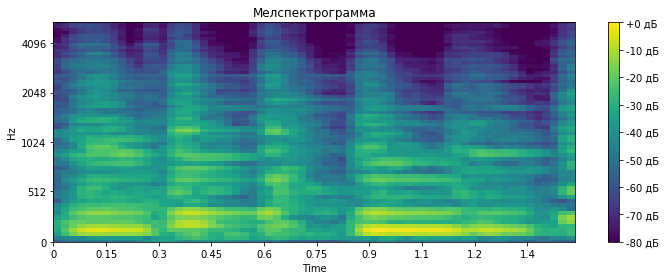

In [37]:
sample_x, sample_y = test_dset[2]
print(id_to_label[sample_y])
plt.figure(figsize=(10, 4))
colors = 'viridis'
specshow(sample_x[0], y_axis='mel', fmax=sample_rate//2, x_axis='time', cmap=colors)
plt.colorbar(format='%+2.0f дБ')
plt.title('Мелспектрограмма')
plt.tight_layout()
plt.show()

In [38]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dset, batch_size=41, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dset, batch_size=41, shuffle=False, num_workers=0)

In [39]:
from sklearn.metrics import accuracy_score

In [40]:
n_epoch = 50
criterion = nn.CrossEntropyLoss()
network = DummyNetwork()
# можно попробовать другой optimizer, тоже считается улучшением
optimizer = optim.SGD(network.parameters(), lr=0.001)

train_loss = []
test_loss = []

train_acc = []
test_acc = []

for e in range(n_epoch):
    print('epoch #', e)
    # train
    loss_list = []
    outputs = []
    targets = []
    for i_batch, sample_batched in enumerate(train_loader):
        x, y = sample_batched
        optimizer.zero_grad()

        output = network(x)
        outputs.append(output.detach().numpy().argmax(axis=1))
    
        target = y
        targets.append(target)
        
        loss = criterion(output, target.long())
        loss_list.append(loss.item())
        loss.backward()
        optimizer.step()
    y_true = np.hstack(targets)
    y_pred = np.hstack(outputs)
    acc = accuracy_score(y_true, y_pred)
    train_loss.append(np.mean(loss_list))
    train_acc.append(acc)
    print('mean train loss:', train_loss[-1])
    print('train accuracy:', acc)
    
    loss_list = []
    outputs = []
    targets = []
    with torch.no_grad():
        for i_batch, sample_batched in enumerate(test_loader):
            x, y = sample_batched
            optimizer.zero_grad()

            output = network(x)
            outputs.append(output.detach().numpy().argmax(axis=1))

            target = y
            targets.append(target)

            loss = criterion(output, target.long())
            loss_list.append(loss.item())
#             loss.backward()
#             optimizer.step()
            
        y_true = np.hstack(targets)
        y_pred = np.hstack(outputs)
        acc = accuracy_score(y_true, y_pred)
        test_loss.append(np.mean(loss_list))
        test_acc.append(acc)
        print('mean test loss:', test_loss[-1])
        print('test accuracy:', acc)

epoch # 0
mean train loss: 3.5413402902836704
train accuracy: 0.11010558069381599
mean test loss: 21.282464118230912
test accuracy: 0.022287390029325515
epoch # 1
mean train loss: 3.1789818758867225
train accuracy: 0.20361990950226244
mean test loss: 18.63562129792713
test accuracy: 0.026979472140762465
epoch # 2
mean train loss: 2.8794686113085066
train accuracy: 0.2631975867269985
mean test loss: 15.052553358532133
test accuracy: 0.022287390029325515
epoch # 3
mean train loss: 2.6983622044933084
train accuracy: 0.2956259426847662
mean test loss: 14.18953105381557
test accuracy: 0.026392961876832845
epoch # 4
mean train loss: 2.5619487105583656
train accuracy: 0.33559577677224733
mean test loss: 6.295383589608329
test accuracy: 0.05161290322580645
epoch # 5
mean train loss: 2.400122453971785
train accuracy: 0.36048265460030166
mean test loss: 12.412500177110944
test accuracy: 0.03167155425219941
epoch # 6
mean train loss: 2.4281078650026906
train accuracy: 0.3863750628456511
mean test

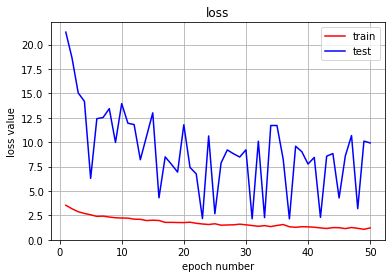

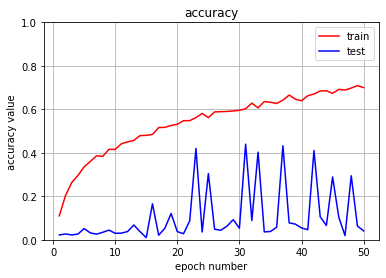

In [41]:
epochs = np.arange(1, n_epoch+1)

axes = plt.gca()
axes.set_ylim([0,max(max(train_loss), max(test_loss))+1])
plt.plot(epochs, train_loss, 'r', label='train')
plt.plot(epochs, test_loss, 'b', label='test')
plt.title('loss')
plt.xlabel('epoch number')
plt.ylabel('loss value')
plt.legend()
plt.grid()
plt.show()


axes = plt.gca()
axes.set_ylim([0,1])
plt.plot(epochs, train_acc, 'r', label='train')
plt.plot(epochs, test_acc, 'b', label='test')
plt.title('accuracy')
plt.xlabel('epoch number')
plt.ylabel('accuracy value')
plt.legend()
plt.grid()
plt.show()

In [118]:
print('Максимальный accuracy для test: {:.2f}%'.format(max(test_acc)))

Максимальный accuracy для test: 43.98%


Тест №1 меняем sample_rate на 8000, fft_size = 2048 и время на 128

In [3]:
# Подгружаем ранее сохраненные извлеченные mel признаки где sample_rate = 8000, fft_size = 2048, и метки

# считываем дынные из файла
with open(path + 'all_data_mel.pickle', 'rb') as f:
    x = pickle.load(f)
    
with open(path + 'all_labels.pickle', 'rb') as f:
    y = pickle.load(f)

In [4]:
x[0].shape

(128, 6)

In [8]:
def prepare_shape(feature):
    tmp = feature
    N = 128 # размер во времени (можно увеличить, должно стать лучше)
    while tmp.shape[1] < N:
        # можно попробовать сделать np.pad для коротких файлов, вместо повторения до необходимой длины
        tmp = np.hstack((tmp, tmp))
    # случайный сдвиг должен улучшить результат (для этого нужно функцию перенести в EventDetectionDataset)
    tmp = tmp[np.newaxis, :, :N]
    return tmp

In [9]:
power_to_db_x = []
for i in x:
    power_to_db_x.append(prepare_shape(power_to_db(i)))

In [30]:
train_data_2, test_data_2, train_label_2, test_label_2 = train_test_split(power_to_db_x, y, test_size=0.30, random_state=42)

In [31]:
print(len(train_data_2), len(train_label_2))
print(len(test_data_2), len(test_label_2))

3978 3978
1705 1705


In [16]:
x_test_2 = np.asarray(test_data_2, dtype=np.float32)
x_tr_2 = np.asarray(train_data_2, dtype=np.float32)

y_test_2 = np.asarray(test_label_2)
y_tr_2 = np.asarray(train_label_2)

In [70]:
from torch.utils.data import Dataset


class EventDetectionDataset(Dataset):
    def __init__(self, x, y=None):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        # добавить prepare_shape
        if self.y is not None:
            return self.x[idx], self.y[idx]
        return self.x[idx]

In [71]:
train_dset_2 = EventDetectionDataset(x_tr_2, y_tr_2)
test_dset_2 = EventDetectionDataset(x_test_2, y_test_2)

In [72]:
print(x_tr_2.shape, y_tr_2.shape)
print(x_test_2.shape, y_test_2.shape)

(3978, 1, 128, 128) (3978,)
(1705, 1, 128, 128) (1705,)


In [73]:
sample_rate = 8000

Double_bass


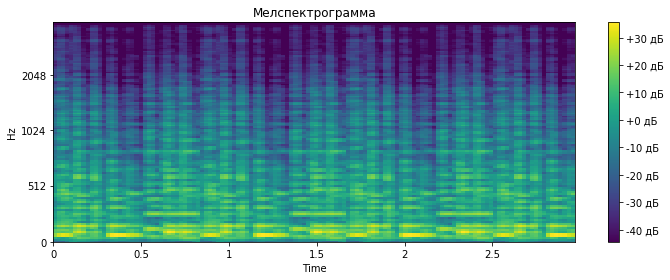

In [75]:
sample_x, sample_y = test_dset_2[2]
print(id_to_label[sample_y])
plt.figure(figsize=(10, 4))
colors = 'viridis'
specshow(sample_x[0], y_axis='mel', fmax=sample_rate//2, x_axis='time', cmap=colors)
plt.colorbar(format='%+2.0f дБ')
plt.title('Мелспектрограмма')
plt.tight_layout()
plt.show()

In [76]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dset_2, batch_size=41, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dset_2, batch_size=41, shuffle=False, num_workers=0)

In [77]:
from sklearn.metrics import accuracy_score

In [98]:
import numpy as np
import pandas as pd
import soundfile as sf
import torch.nn.functional as F
import torch.nn as nn
import torch
import torch.optim as optim


class myNetwork(nn.Module):
    def __init__(self):
        super(myNetwork, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, stride=(2, 2))
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3, stride=(1, 1))
        self.conv3 = nn.Conv2d(in_channels=96, out_channels=64, kernel_size=3, stride=(1, 1))
        
        self.mp = nn.MaxPool2d(kernel_size=(2, 2), stride=(1, 1))
        
        self.dropout1 = nn.Dropout(p=0.3)
        self.dropout2 = nn.Dropout(p=0.3)
        self.dropout3 = nn.Dropout(p=0.3)
        
        self.bn1 = nn.BatchNorm2d(num_features=64)
        self.bn2 = nn.BatchNorm2d(num_features=96)
        self.bn3 = nn.BatchNorm2d(num_features=64)
        
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(193600, 41)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout3(x)
        
        x = self.flat(x)
        # здесь можно еще добавить полносвязных слой или слои
        x = self.fc1(x)
        return x


In [95]:
n_epoch = 50
criterion = nn.CrossEntropyLoss()
network = myNetwork()
# можно попробовать другой optimizer, тоже считается улучшением
optimizer = optim.SGD(network.parameters(), lr=0.001)

train_loss = []
test_loss = []

train_acc = []
test_acc = []

for e in range(n_epoch):
    print('epoch #', e)
    # train
    loss_list = []
    outputs = []
    targets = []
    for i_batch, sample_batched in enumerate(train_loader):
        x, y = sample_batched
        optimizer.zero_grad()

        output = network(x)
        outputs.append(output.detach().numpy().argmax(axis=1))
    
        target = y
        targets.append(target)
        
        loss = criterion(output, target.long())
        loss_list.append(loss.item())
        loss.backward()
        optimizer.step()
    y_true = np.hstack(targets)
    y_pred = np.hstack(outputs)
    acc = accuracy_score(y_true, y_pred)
    train_loss.append(np.mean(loss_list))
    train_acc.append(acc)
    print('mean train loss:', train_loss[-1])
    print('train accuracy:', acc)
    
    loss_list = []
    outputs = []
    targets = []
    with torch.no_grad():
        for i_batch, sample_batched in enumerate(test_loader):
            x, y = sample_batched
            optimizer.zero_grad()

            output = network(x)
            outputs.append(output.detach().numpy().argmax(axis=1))

            target = y
            targets.append(target)

            loss = criterion(output, target.long())
            loss_list.append(loss.item())
#             loss.backward()
#             optimizer.step()
            
        y_true = np.hstack(targets)
        y_pred = np.hstack(outputs)
        acc = accuracy_score(y_true, y_pred)
        test_loss.append(np.mean(loss_list))
        test_acc.append(acc)
        print('mean test loss:', test_loss[-1])
        print('test accuracy:', acc)

epoch # 0
mean train loss: 13.233984830428144
train accuracy: 0.10558069381598793
mean test loss: 70.27073051815941
test accuracy: 0.03519061583577713
epoch # 1
mean train loss: 5.908347149284518
train accuracy: 0.24358974358974358
mean test loss: 37.892809095836824
test accuracy: 0.03225806451612903
epoch # 2
mean train loss: 4.572071783396662
train accuracy: 0.3046757164404223
mean test loss: 67.03773353213356
test accuracy: 0.013489736070381233
epoch # 3
mean train loss: 4.230124252791307
train accuracy: 0.3494218200100553
mean test loss: 27.532536279587518
test accuracy: 0.0187683284457478
epoch # 4
mean train loss: 2.949733167278523
train accuracy: 0.4228255404725993
mean test loss: 44.326167606172106
test accuracy: 0.03167155425219941
epoch # 5
mean train loss: 3.060057441799008
train accuracy: 0.4454499748617396
mean test loss: 51.707845597040084
test accuracy: 0.03167155425219941
epoch # 6
mean train loss: 2.8887798444424964
train accuracy: 0.46907993966817496
mean test loss: 2

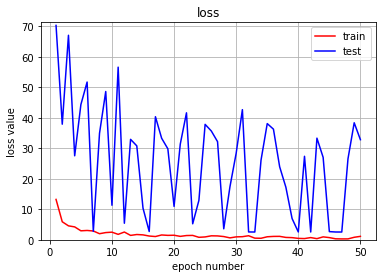

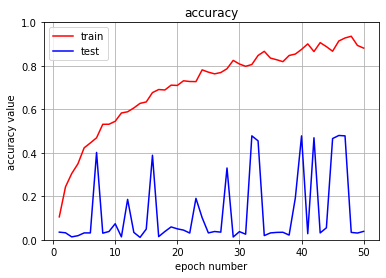

In [96]:
epochs = np.arange(1, n_epoch+1)

axes = plt.gca()
axes.set_ylim([0,max(max(train_loss), max(test_loss))+1])
plt.plot(epochs, train_loss, 'r', label='train')
plt.plot(epochs, test_loss, 'b', label='test')
plt.title('loss')
plt.xlabel('epoch number')
plt.ylabel('loss value')
plt.legend()
plt.grid()
plt.show()


axes = plt.gca()
axes.set_ylim([0,1])
plt.plot(epochs, train_acc, 'r', label='train')
plt.plot(epochs, test_acc, 'b', label='test')
plt.title('accuracy')
plt.xlabel('epoch number')
plt.ylabel('accuracy value')
plt.legend()
plt.grid()
plt.show()

In [113]:
print('Максимальный accuracy для test: {:.2f}%'.format(max(test_acc)*100))

Максимальный accuracy для test: 47.98%


Тест №2 меняем оптимизатор на AdamW

In [99]:
class myNetwork(nn.Module):
    def __init__(self):
        super(myNetwork, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, stride=(2, 2))
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3, stride=(1, 1))
        self.conv3 = nn.Conv2d(in_channels=96, out_channels=64, kernel_size=3, stride=(1, 1))
        
        self.mp = nn.MaxPool2d(kernel_size=(2, 2), stride=(1, 1))
        
        self.dropout1 = nn.Dropout(p=0.3)
        self.dropout2 = nn.Dropout(p=0.3)
        self.dropout3 = nn.Dropout(p=0.3)
        
        self.bn1 = nn.BatchNorm2d(num_features=64)
        self.bn2 = nn.BatchNorm2d(num_features=96)
        self.bn3 = nn.BatchNorm2d(num_features=64)
        
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(193600, 41)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout3(x)
        
        x = self.flat(x)
        # здесь можно еще добавить полносвязных слой или слои
        x = self.fc1(x)
        return x

In [100]:
n_epoch = 50
criterion = nn.CrossEntropyLoss()
network = myNetwork()
# можно попробовать другой optimizer, тоже считается улучшением
optimizer = optim.AdamW(network.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=5e-5, amsgrad=True)

train_loss = []
test_loss = []

train_acc = []
test_acc = []

for e in range(n_epoch):
    print('epoch #', e)
    # train
    loss_list = []
    outputs = []
    targets = []
    for i_batch, sample_batched in enumerate(train_loader):
        x, y = sample_batched
        optimizer.zero_grad()

        output = network(x)
        outputs.append(output.detach().numpy().argmax(axis=1))
    
        target = y
        targets.append(target)
        
        loss = criterion(output, target.long())
        loss_list.append(loss.item())
        loss.backward()
        optimizer.step()
    y_true = np.hstack(targets)
    y_pred = np.hstack(outputs)
    acc = accuracy_score(y_true, y_pred)
    train_loss.append(np.mean(loss_list))
    train_acc.append(acc)
    print('mean train loss:', train_loss[-1])
    print('train accuracy:', acc)
    
    loss_list = []
    outputs = []
    targets = []
    with torch.no_grad():
        for i_batch, sample_batched in enumerate(test_loader):
            x, y = sample_batched
            optimizer.zero_grad()

            output = network(x)
            outputs.append(output.detach().numpy().argmax(axis=1))

            target = y
            targets.append(target)

            loss = criterion(output, target.long())
            loss_list.append(loss.item())
#             loss.backward()
#             optimizer.step()
            
        y_true = np.hstack(targets)
        y_pred = np.hstack(outputs)
        acc = accuracy_score(y_true, y_pred)
        test_loss.append(np.mean(loss_list))
        test_acc.append(acc)
        print('mean test loss:', test_loss[-1])
        print('test accuracy:', acc)

epoch # 0
mean train loss: 67.12654995304227
train accuracy: 0.12242332830568124
mean test loss: 34.903205235799156
test accuracy: 0.16774193548387098
epoch # 1
mean train loss: 21.922282841740824
train accuracy: 0.2383107088989442
mean test loss: 23.143430346534366
test accuracy: 0.16422287390029325
epoch # 2
mean train loss: 15.354564063403071
train accuracy: 0.2986425339366516
mean test loss: 13.741013674508958
test accuracy: 0.29560117302052785
epoch # 3
mean train loss: 8.845939964056015
train accuracy: 0.39718451483157363
mean test loss: 12.192319688342867
test accuracy: 0.27976539589442817
epoch # 4
mean train loss: 6.262807218395934
train accuracy: 0.4494720965309201
mean test loss: 10.702354124614171
test accuracy: 0.2504398826979472
epoch # 5
mean train loss: 6.083357893690771
train accuracy: 0.4803921568627451
mean test loss: 7.469501211529686
test accuracy: 0.34017595307917886
epoch # 6
mean train loss: 4.2790176077764865
train accuracy: 0.5256410256410257
mean test loss: 7

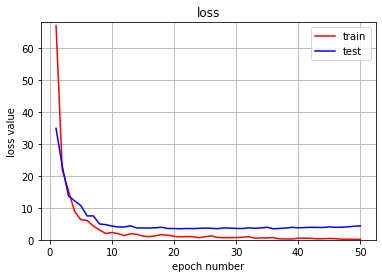

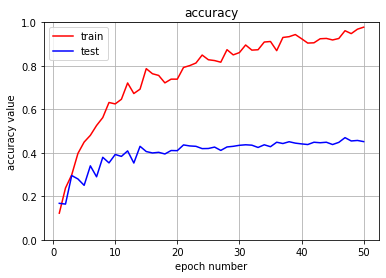

In [101]:
epochs = np.arange(1, n_epoch+1)

axes = plt.gca()
axes.set_ylim([0,max(max(train_loss), max(test_loss))+1])
plt.plot(epochs, train_loss, 'r', label='train')
plt.plot(epochs, test_loss, 'b', label='test')
plt.title('loss')
plt.xlabel('epoch number')
plt.ylabel('loss value')
plt.legend()
plt.grid()
plt.show()


axes = plt.gca()
axes.set_ylim([0,1])
plt.plot(epochs, train_acc, 'r', label='train')
plt.plot(epochs, test_acc, 'b', label='test')
plt.title('accuracy')
plt.xlabel('epoch number')
plt.ylabel('accuracy value')
plt.legend()
plt.grid()
plt.show()

In [111]:
print('Максимальный accuracy для test: {:.2f}%'.format(max(test_acc)*100))

Максимальный accuracy для test: 46.98%


Тест 3 добавляем в нейронную сеть полносвязный слой

In [129]:
import numpy as np
import pandas as pd
import soundfile as sf
import torch.nn.functional as F
import torch.nn as nn
import torch
import torch.optim as optim


class myNetwork(nn.Module):
    def __init__(self):
        super(myNetwork, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, stride=(2, 2))
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3, stride=(1, 1))
        self.conv3 = nn.Conv2d(in_channels=96, out_channels=64, kernel_size=3, stride=(1, 1))
        
        self.mp = nn.MaxPool2d(kernel_size=(2, 2), stride=(1, 1))
        
        self.dropout1 = nn.Dropout(p=0.3)
        self.dropout2 = nn.Dropout(p=0.3)
        self.dropout3 = nn.Dropout(p=0.3)
        
        self.bn1 = nn.BatchNorm2d(num_features=64)
        self.bn2 = nn.BatchNorm2d(num_features=96)
        self.bn3 = nn.BatchNorm2d(num_features=64)
        
        self.flat = nn.Flatten()
        
        self.fc1 = nn.Linear(193600, 100)
        
        self.fc2 = nn.Linear(100, 41)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout3(x)
        
        x = self.flat(x)
        # здесь можно еще добавить полносвязных слой или слои
        x = self.fc1(x)
        x = self.fc2(x)
        return x


In [130]:
n_epoch = 50
criterion = nn.CrossEntropyLoss()
network = myNetwork()
# можно попробовать другой optimizer, тоже считается улучшением
optimizer = optim.SGD(network.parameters(), lr=0.001)

train_loss = []
test_loss = []

train_acc = []
test_acc = []

for e in range(n_epoch):
    print('epoch #', e)
    # train
    loss_list = []
    outputs = []
    targets = []
    for i_batch, sample_batched in enumerate(train_loader):
        x, y = sample_batched
        optimizer.zero_grad()

        output = network(x)
        outputs.append(output.detach().numpy().argmax(axis=1))
    
        target = y
        targets.append(target)
        
        loss = criterion(output, target.long())
        loss_list.append(loss.item())
        loss.backward()
        optimizer.step()
    y_true = np.hstack(targets)
    y_pred = np.hstack(outputs)
    acc = accuracy_score(y_true, y_pred)
    train_loss.append(np.mean(loss_list))
    train_acc.append(acc)
    print('mean train loss:', train_loss[-1])
    print('train accuracy:', acc)
    
    loss_list = []
    outputs = []
    targets = []
    with torch.no_grad():
        for i_batch, sample_batched in enumerate(test_loader):
            x, y = sample_batched
            optimizer.zero_grad()

            output = network(x)
            outputs.append(output.detach().numpy().argmax(axis=1))

            target = y
            targets.append(target)

            loss = criterion(output, target.long())
            loss_list.append(loss.item())
#             loss.backward()
#             optimizer.step()
            
        y_true = np.hstack(targets)
        y_pred = np.hstack(outputs)
        acc = accuracy_score(y_true, y_pred)
        test_loss.append(np.mean(loss_list))
        test_acc.append(acc)
        print('mean test loss:', test_loss[-1])
        print('test accuracy:', acc)

epoch # 0
mean train loss: 5.554202687983611
train accuracy: 0.1008044243338361
mean test loss: 29.98388149624779
test accuracy: 0.03401759530791789
epoch # 1
mean train loss: 3.124310161386217
train accuracy: 0.26244343891402716
mean test loss: 20.794796262468612
test accuracy: 0.0281524926686217
epoch # 2
mean train loss: 2.693476707351451
train accuracy: 0.31975867269984914
mean test loss: 23.776552926926385
test accuracy: 0.012316715542521995
epoch # 3
mean train loss: 2.458609793867384
train accuracy: 0.38838612368024134
mean test loss: 26.745646794637043
test accuracy: 0.022287390029325515
epoch # 4
mean train loss: 2.323184923249848
train accuracy: 0.41277023629964804
mean test loss: 23.907434826805478
test accuracy: 0.03167155425219941
epoch # 5
mean train loss: 2.132781551808727
train accuracy: 0.4670688788335847
mean test loss: 15.044434570130848
test accuracy: 0.01935483870967742
epoch # 6
mean train loss: 1.9482859750183261
train accuracy: 0.49145299145299143
mean test loss

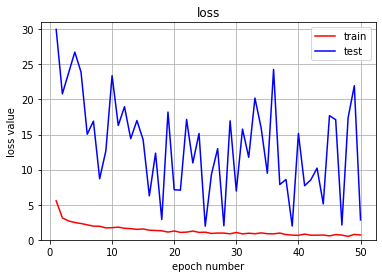

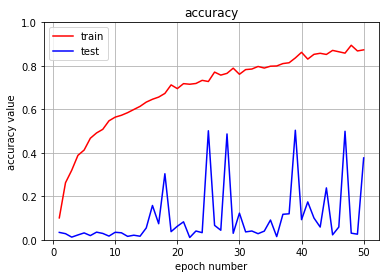

In [131]:
epochs = np.arange(1, n_epoch+1)

axes = plt.gca()
axes.set_ylim([0,max(max(train_loss), max(test_loss))+1])
plt.plot(epochs, train_loss, 'r', label='train')
plt.plot(epochs, test_loss, 'b', label='test')
plt.title('loss')
plt.xlabel('epoch number')
plt.ylabel('loss value')
plt.legend()
plt.grid()
plt.show()


axes = plt.gca()
axes.set_ylim([0,1])
plt.plot(epochs, train_acc, 'r', label='train')
plt.plot(epochs, test_acc, 'b', label='test')
plt.title('accuracy')
plt.xlabel('epoch number')
plt.ylabel('accuracy value')
plt.legend()
plt.grid()
plt.show()

In [132]:
print('Максимальный accuracy для test: {:.2f}%'.format(max(test_acc)*100))

Максимальный accuracy для test: 50.38%


Обучение с помощью Keras

In [32]:
# Подготовка признаков
x_test_2 = np.asarray(test_data_2).reshape([-1, 128, 128, 1])
x_tr_2 = np.asarray(train_data_2).reshape([-1, 128, 128, 1])
x_test_2.shape

(1705, 128, 128, 1)

In [35]:
x_tr_2.shape

(3978, 128, 128, 1)

In [36]:
from sklearn import preprocessing

# Подготовка меток
lb_train = preprocessing.LabelBinarizer()
lb_test = preprocessing.LabelBinarizer()

train_label_2_matrix = lb_train.fit_transform(train_label_2)
test_label_2_matrix = lb_test.fit_transform(test_label_2)

In [37]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import SGD

In [38]:
# Архитектура сети для Keras
epochs=50
num_labels = 41

model = Sequential()
model.add(Conv2D(64, kernel_size = 5, strides=2,input_shape=(128,128, 1)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size= 2, strides=1))
model.add(Dropout(0.3))

model.add(Conv2D(96, kernel_size = 3, strides=1))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size= 2, strides=1))
model.add(Dropout(0.3))

model.add(Conv2D(64, kernel_size = 3, strides=1))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size= 2, strides=1))
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [40]:
import time

tik = time.time()

model.compile(
  optimizer=SGD(lr=0.001),
  loss='categorical_crossentropy',
  metrics=['acc'],
)

history_1 = model.fit(x_tr_2, train_label_2_matrix,
          batch_size=41,
          epochs=epochs,
          validation_data=(x_test_2, test_label_2_matrix))

tok = time.time()
print(tok-tik)

Instructions for updating:
Use tf.cast instead.
Train on 3978 samples, validate on 1705 samples
Epoch 1/50
3978/3978 [==============================] - 32s 8ms/step - loss: 12.0796 - acc: 0.0807 - val_loss: 9.7848 - val_acc: 0.1202
Epoch 2/50
3978/3978 [==============================] - 26s 7ms/step - loss: 10.1226 - acc: 0.1332 - val_loss: 8.0576 - val_acc: 0.1572
Epoch 3/50
3978/3978 [==============================] - 26s 7ms/step - loss: 7.6617 - acc: 0.1981 - val_loss: 15.7967 - val_acc: 0.0199
Epoch 4/50
3978/3978 [==============================] - 26s 7ms/step - loss: 15.6600 - acc: 0.0284 - val_loss: 15.6590 - val_acc: 0.0199
Epoch 5/50
3978/3978 [==============================] - 26s 7ms/step - loss: 15.6535 - acc: 0.0284 - val_loss: 14.8492 - val_acc: 0.0199
Epoch 6/50
3978/3978 [==============================] - 26s 7ms/step - loss: 9.2292 - acc: 0.1913 - val_loss: 15.7463 - val_acc: 0.0199
Epoch 7/50
3978/3978 [==============================] - 27s 7ms/step - loss: 7.9803 - 

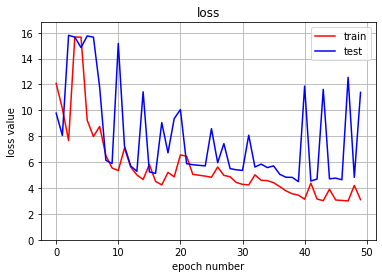

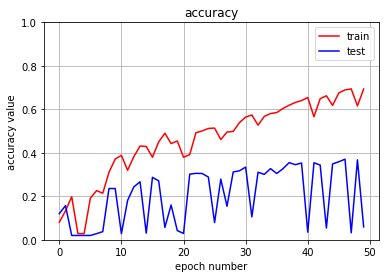

In [56]:
epochs = np.arange(1, 50+1)

axes = plt.gca()
axes.set_ylim([0,max(max(history_1.history['loss']), max(history_1.history['val_loss']))+1])
plt.plot(history_1.epoch,history_1.history['loss'], 'r', label='train')
plt.plot(history_1.epoch,history_1.history['val_loss'], 'b', label='test')
plt.title('loss')
plt.xlabel('epoch number')
plt.ylabel('loss value')
plt.legend()
plt.grid()
plt.show()


axes = plt.gca()
axes.set_ylim([0,1])
plt.plot(history_1.epoch,history_1.history['acc'], 'r', label='train')
plt.plot(history_1.epoch,history_1.history['val_acc'], 'b', label='test')
plt.title('accuracy')
plt.xlabel('epoch number')
plt.ylabel('accuracy value')
plt.legend()
plt.grid()
plt.show()

In [58]:
print('Максимальный accuracy для test: {:.2f}%'.format(max(history_1.history['val_acc'])*100))

Максимальный accuracy для test: 37.07%


# Проделанная работа:
## Осуществлено деление признаков и лейблов с помошью train_test_split (random_state=42)
    Обученная модель на валидации показала лучший результа 44% для:
    времени 64;
    sample_rate 1125;
    fft_size 1024
## Ранее мною были извлечены mel признаки с параметрами melspectrogram по умолчанию и sample_rate 8000
    1) Признаки были преобразованы с помощью power_to_db и время было увеличино до 128
    2) Линейный слой нейронной сети был увеличен с 33856 до 193600, как того требовала сеть
    3) Обученная модель на валидации показала лучший результат 48%
## Был также использован оптимизатор Adam_W с параметрами:
    weight_decay=5e-5, 
    amsgrad=True
    Обученная модель на валидации показала лучший результат 47%
## Был добавлен линейный слой в архитектуру нейронной сети
    Обученная модель на валидации показала лучший результат 50%
    Оптимизатор SGD
## Чисто любобытно выбо проверить, как быстро Keras справится с поставленной задачей
    Обучение модель через керас на 50 эпохах справилось за 22 минуты, тогда как на торче на это потребовалось примерно 8 часов, однако производительность системы упала на 11% в стравнении с пунктом 2 (48%), думаю если поставить эпох 100, то результаты выравятся, а скорость при этом останется лучшей за керасом.
    Обученная модель на валидации показала лучший результат 37%